## Setup

#### Importing necessary libraries

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MultiLabelBinarizer

import combined_data

%matplotlib inline


## Data Prepartaion

### Loading movie titles

In [54]:
columns = [0,1,2]
movies = pd.read_csv(
    "netflix-data/movie_titles.csv",
    encoding="ISO-8859-1",
    usecols=columns
)
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      17770 non-null  int64  
 1   Year    17763 non-null  float64
 2   Title   17770 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 416.6+ KB


Only 7 titles have missing data so they are dropped and years converted to int values

In [55]:
movies.dropna(inplace=True)
movies.Year = movies.Year.astype(int)
movies

,ID,Year,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004,Fidel Castro: American Experience
17767,17768,2000,Epoch
17768,17769,2003,The Company


### Merging genre and runtime information found in another dataset

In [56]:
movie_info = pd.read_csv("data/movie_basics.csv")
movie_info.drop(
    ["movie_id", "original_title"],
    axis=1, inplace=True
)
movie_info.rename(columns={"primary_title" : "title"}, inplace=True)
movie_info.rename(columns={"start_year" : "year"}, inplace=True)
movie_info.rename(columns={"runtime_minutes" : "runtime"}, inplace=True)
movie_info.drop_duplicates(subset="title", keep="first", inplace=True)

movie_info

,title,year,runtime,genres
0,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,One Day Before the Rainy Season,2019,114.0,"Biography,Drama"
2,The Other Side of the Wind,2018,122.0,Drama
3,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...
146139,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,Dankyavar Danka,2013,NaN,Comedy
146142,6 Gunn,2017,116.0,NaN


In [57]:
movie_info.duplicated().sum()

0

Dropping duplicate variables

In [58]:
movies = pd.merge(movies, movie_info, left_on="Title", right_on="title")
movies.drop("Title", axis=1, inplace=True)
movies.drop("Year", axis=1, inplace=True)

movies

,ID,title,year,runtime,genres
0,6,Sick,2011,99.0,"Comedy,Drama"
1,10,Fighter,2019,NaN,"Drama,Sport"
2,45,The Love Letter,2011,12.0,"Adventure,Documentary"
3,17721,The Love Letter,2011,12.0,"Adventure,Documentary"
4,48,Justice League,2017,120.0,"Action,Adventure,Fantasy"
...,...,...,...,...,...
2118,17749,No End,2015,NaN,"Horror,Thriller"
2119,17752,Out of Order,2012,67.0,Comedy
2120,17754,On the Ropes,2011,94.0,Comedy
2121,17758,Prophecy,2015,119.0,Mystery


Dealing with missing data

In [59]:
movies.isna().sum()

ID           0
title        0
year         0
runtime    435
genres      65
dtype: int64

In [60]:
movies.runtime.fillna(-1, inplace=True)
movies.genres.fillna("Unknown", inplace=True)

In [61]:
movies.isna().sum()

ID         0
title      0
year       0
runtime    0
genres     0
dtype: int64

In [62]:
movies

,ID,title,year,runtime,genres
0,6,Sick,2011,99.0,"Comedy,Drama"
1,10,Fighter,2019,-1.0,"Drama,Sport"
2,45,The Love Letter,2011,12.0,"Adventure,Documentary"
3,17721,The Love Letter,2011,12.0,"Adventure,Documentary"
4,48,Justice League,2017,120.0,"Action,Adventure,Fantasy"
...,...,...,...,...,...
2118,17749,No End,2015,-1.0,"Horror,Thriller"
2119,17752,Out of Order,2012,67.0,Comedy
2120,17754,On the Ropes,2011,94.0,Comedy
2121,17758,Prophecy,2015,119.0,Mystery


### Examining the ratings dataset

Converting `combined_data_n.txt` files into feather format if necessary and loading them for analysis. (Functions defined in `combined_data.py`) 

# RESET TO 10 MILLION

In [63]:
dev_dataset_rows = 1000000 #number of records to use for the analysis
combined_data.initialize_all_data()
ratings = pd.read_feather(combined_data.combined_ratings_path())
ratings = ratings.head(dev_dataset_rows)
ratings

,movie,user,rating
0,1,1488844,3
1,1,822109,5
2,1,885013,4
3,1,30878,4
4,1,823519,3
...,...,...,...
999995,225,1441086,2
999996,225,2104133,5
999997,225,442222,2
999998,225,324510,1


In [64]:
ratings = pd.merge(ratings, movies, how="inner", left_on="movie", right_on="ID")
ratings.drop(["ID", "title"], axis=1, inplace=True)
ratings

,movie,user,rating,year,runtime,genres
0,6,2031561,1,2011,99.0,"Comedy,Drama"
1,6,1176140,1,2011,99.0,"Comedy,Drama"
2,6,2336133,2,2011,99.0,"Comedy,Drama"
3,6,1521836,1,2011,99.0,"Comedy,Drama"
4,6,117277,3,2011,99.0,"Comedy,Drama"
...,...,...,...,...,...,...
122178,222,1573865,3,2012,105.0,Drama
122179,222,1978328,3,2012,105.0,Drama
122180,222,1697157,1,2012,105.0,Drama
122181,222,1008445,3,2012,105.0,Drama


In [65]:
ratings.dtypes

movie        int64
user         int64
rating       int64
year         int64
runtime    float64
genres      object
dtype: object

In [66]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122183 entries, 0 to 122182
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   movie    122183 non-null  int64  
 1   user     122183 non-null  int64  
 2   rating   122183 non-null  int64  
 3   year     122183 non-null  int64  
 4   runtime  122183 non-null  float64
 5   genres   122183 non-null  object 
dtypes: float64(1), int64(4), object(1)
memory usage: 5.6+ MB


The dataset has no missing values

In [67]:
ratings.isna().sum()

movie      0
user       0
rating     0
year       0
runtime    0
genres     0
dtype: int64

Dataframe shape

In [68]:
ratings.shape

(122183, 6)

No duplicate ratings in the dataset

In [69]:
ratings.duplicated().any()

False

## Exploratory Data Analysis

### Ratings bar plot

In [70]:
ratings_count = ratings.rating.value_counts()
ratings_count

rating
4    45736
3    32094
5    29997
2    10217
1     4139
Name: count, dtype: int64

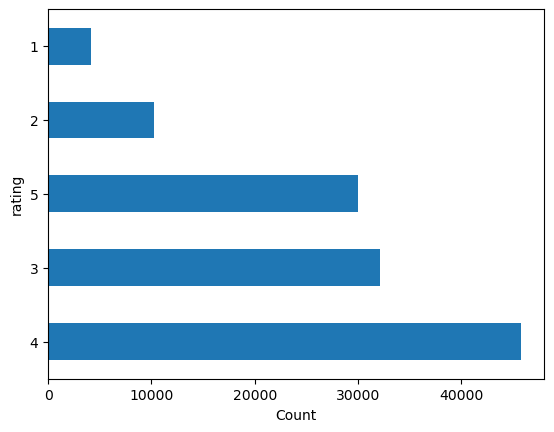

In [71]:
ratings_count.plot(kind="barh", xlabel="Count");

#### Observation

The vast majority of films are rated favorably or neutral<hr>

### Ratings box plot

In [72]:
ratings.rating.median()

4.0

In [73]:
q1 = np.percentile(ratings.rating, 25)
q3 = np.percentile(ratings.rating, 75)
iqr = q3 - q1
print(f"Q1: {q1}\nQ3:{q3}\nInterquartile Range:{iqr}")

Q1: 3.0
Q3:4.0
Interquartile Range:1.0


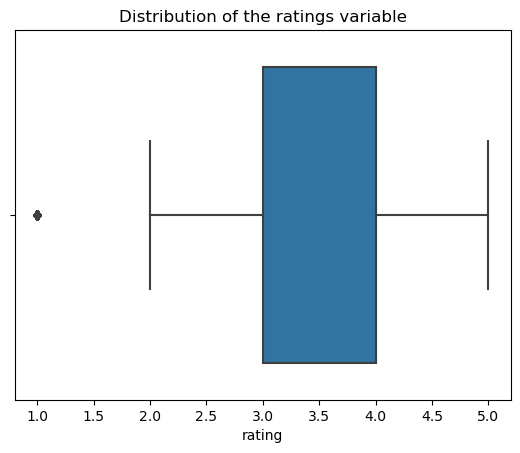

In [74]:
sns.boxplot(x='rating', data=ratings)
plt.title("Distribution of the ratings variable");

#### Observations
- The ratings have a median of 4 and an IQR of 1
- There appears to be outliers at the lower end of the ratings which might indicate class imbalance
<hr>

### Reducing rating categories (Negative: 0, Positive: 1)

In [75]:
ratings["category"] = ratings.rating.apply(
    lambda x:
        0 if x <= 3
        else(1 )
)
ratings.head()

,movie,user,rating,year,runtime,genres,category
0,6,2031561,1,2011,99.0,"Comedy,Drama",0
1,6,1176140,1,2011,99.0,"Comedy,Drama",0
2,6,2336133,2,2011,99.0,"Comedy,Drama",0
3,6,1521836,1,2011,99.0,"Comedy,Drama",0
4,6,117277,3,2011,99.0,"Comedy,Drama",0


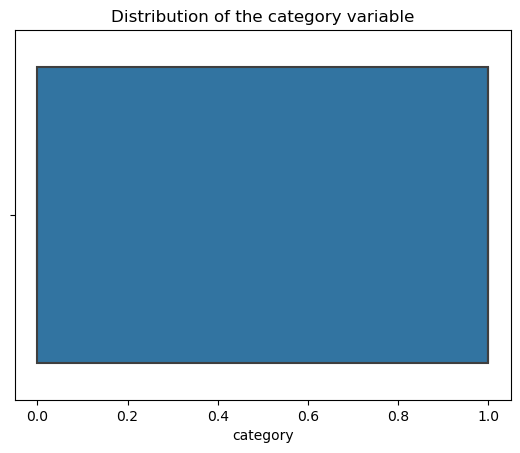

In [76]:
sns.boxplot(x='category', data=ratings)
plt.title("Distribution of the category variable");

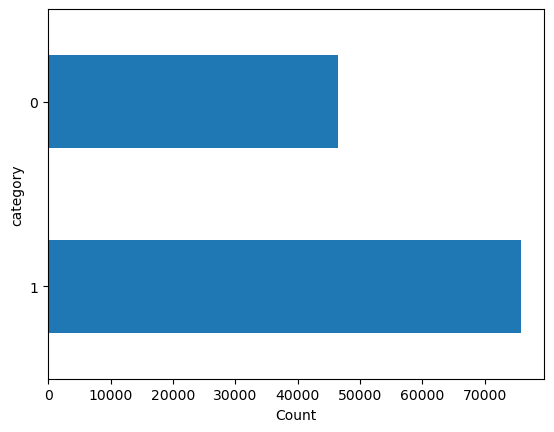

In [77]:
ratings_count = ratings.category.value_counts()
ratings_count.plot(kind="barh", xlabel="Count");

#### Observations
Reducing the categories reduces the strength of the outliers
<hr>

With our rating categories set, we can drop the original rating column. Its high correlation with category would give little information

In [78]:
ratings.drop("rating", axis=1, inplace=True)
ratings

,movie,user,year,runtime,genres,category
0,6,2031561,2011,99.0,"Comedy,Drama",0
1,6,1176140,2011,99.0,"Comedy,Drama",0
2,6,2336133,2011,99.0,"Comedy,Drama",0
3,6,1521836,2011,99.0,"Comedy,Drama",0
4,6,117277,2011,99.0,"Comedy,Drama",0
...,...,...,...,...,...,...
122178,222,1573865,2012,105.0,Drama,0
122179,222,1978328,2012,105.0,Drama,0
122180,222,1697157,2012,105.0,Drama,0
122181,222,1008445,2012,105.0,Drama,0


### Heatmap

In [79]:
ratings_corr =  ratings.drop("genres", axis=1).corr()
ratings_corr

,movie,user,year,runtime,category
movie,1.000000,-0.003760,-0.056238,-0.142173,0.123148
user,-0.003760,1.000000,0.001585,0.006575,-0.003816
year,-0.056238,0.001585,1.000000,-0.194647,0.199701
runtime,-0.142173,0.006575,-0.194647,1.000000,-0.036105
category,0.123148,-0.003816,0.199701,-0.036105,1.000000


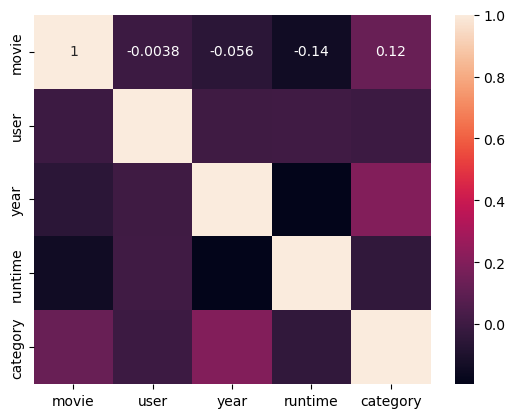

In [80]:
sns.heatmap(ratings_corr, annot=True);

#### Observations
There appears to be no strong correlation between any of the variables. This indicates a non-linear more omplex relationship

## Modeling

In [81]:
mlb = MultiLabelBinarizer()
def genres_ohe(df):
    df['genres'] = df['genres'].str.split(',')
    one_hot_encoded = mlb.fit_transform(df['genres'])
    one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)
    return one_hot_encoded_df

In [82]:
ratings = pd.concat([ratings, genres_ohe(ratings)], axis=1)
ratings.drop("genres", axis=1, inplace=True)

ratings

,movie,user,year,runtime,category,Action,Adventure,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Mystery,Sci-Fi,Sport,Thriller,Unknown,War
0,6,2031561,2011,99.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
1,6,1176140,2011,99.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,6,2336133,2011,99.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3,6,1521836,2011,99.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,6,117277,2011,99.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122178,222,1573865,2012,105.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
122179,222,1978328,2012,105.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
122180,222,1697157,2012,105.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
122181,222,1008445,2012,105.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [83]:
y = ratings.category
X = ratings.drop("category", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [84]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_test, y_preds) * 100, 2)}%")

Accuracy: 57.54%


<hr>

### Hyperparameter Tuning

In [85]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 6, 7],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [5, 6, 7],
    'max_features': [None],
}
clf_grid = DecisionTreeClassifier()
grid = GridSearchCV(estimator=clf_grid, param_grid=param_grid, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
print("Best Parameters:", best_params)


# Get the best estimator
best_estimator = grid.best_estimator_
y_preds_grid = best_estimator.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_preds_grid) :.2%}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Accuracy: 68.20%


In [86]:
tuned_tree = DecisionTreeClassifier(criterion="gini", max_depth=6, max_features=None, min_samples_leaf=6, min_samples_split=2)
tuned_tree.fit(X_train, y_train)
y_preds = tuned_tree.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_preds) :.2%}")

Accuracy: 68.19%


#### Observations
With optimal parameters the model's accuracy increases by roughly 10%<hr>

In [87]:
bagged_tree =  BaggingClassifier(tuned_tree, n_estimators=20)
bagged_tree.fit(X_train, y_train)
train_score = bagged_tree.score(X_train, y_train)
test_score = bagged_tree.score(X_test, y_test)
print(f"Training score:{train_score :.2%}\nTest score: {test_score :.2%}")

Training score:68.05%
Test score: 68.21%


In [88]:
forest = RandomForestClassifier(n_estimators=10, max_depth= 5)
forest.fit(X_train, y_train)
train_score = forest.score(X_train, y_train)
test_score = forest.score(X_test, y_test)
print(f"Training score:{train_score :.2%}\nTest score: {test_score :.2%}")
mean_rf_cv_score = np.mean(cross_val_score(forest, X_train, y_train, cv=3))
print(
    f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}"
)

Training score:67.90%
Test score: 68.04%
Mean Cross Validation Score for Random Forest Classifier: 67.94%


<hr>

In [89]:
pivot_df = ratings.pivot_table(index='user', columns='movie', values='category')
pivot_df.fillna(0, inplace=True)
pivot_df.reset_index(inplace=True)
pivot_df

movie,user,6,10,45,48,55,57,64,75,87,...,166,167,170,172,177,180,181,199,201,222
0,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,134,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85625,2649296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85626,2649323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
85627,2649335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85628,2649401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
X_cluster = pivot_df.drop(['user'], axis=1) 
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_cluster)

# Adding cluster labels to the DataFrame
pivot_df['cluster'] = cluster_labels
pivot_df

/home/ian/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


movie,user,6,10,45,48,55,57,64,75,87,...,167,170,172,177,180,181,199,201,222,cluster
0,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,134,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85625,2649296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
85626,2649323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
85627,2649335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
85628,2649401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [91]:
pivot_df.cluster.value_counts()

cluster
0    30906
1    23105
4    19675
2     7029
3     4915
Name: count, dtype: int64

In [92]:
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_cluster, pivot_df['cluster'], test_size=0.2, random_state=42)
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_cluster, y_train_cluster)
y_pred_cluster = knn_classifier.predict(X_test_cluster)

# Evaluating the classifier
accuracy = accuracy_score(y_test_cluster, y_pred_cluster)
print("Accuracy:", accuracy)


Accuracy: 0.9998832184981898


In [93]:
def get_recs(cluster):
    cluster_data = pivot_df[pivot_df['cluster'] == cluster]
    average_ratings = cluster_data.drop(["user", "cluster"], axis=1).mean(axis=0)  # Calculate average ratings for each movie in the cluster
    recommended_movies = average_ratings.sort_values(ascending=False).head(10)  # Get top recommended movies
    #print(f"Cluster {cluster} recommended movies:")
    #print(recommended_movies)
    return recommended_movies

In [94]:
get_recs(0)

movie
48     0.049829
180    0.034912
57     0.033521
201    0.027179
45     0.013460
55     0.010289
181    0.009610
6      0.008801
125    0.008574
110    0.008510
dtype: float64

In [95]:
def get_user():
    row = ratings.sample(n=1)
    user = row.head(1).user.values[0]
    return user

In [96]:
def get_cluster(user):
    cluster = pivot_df[pivot_df.user == user]
    return cluster.head(1).cluster.values[0]

In [97]:
def get_user_reccs(user):
    cluster = get_cluster(user)
    return get_recs(cluster)

In [98]:
def get_movie_name(id):
    return movies[movies["ID"] == id].title.iloc[0]

In [99]:
get_movie_name(48)

'Justice League'

In [119]:
user = get_user()
print(f"User: {user}")
movie_rec = get_user_reccs(user).index
movie = None

for entry in movie_rec:
    if len(ratings[(ratings.user == user) & (ratings.movie == entry)]) > 0:
        continue #has watched the movie before, skip
    else:
        movie = entry
        break
movie_name = get_movie_name(movie)
print(f"Recommendation: {movie}: {movie_name}")
movie_rec

User: 87378
Recommendation: 199: The Deer Hunter


Index([167, 199, 143, 166, 57, 201, 181, 117, 180, 110], dtype='object', name='movie')

In [120]:
ratings[(ratings.user == user)]

,movie,user,year,runtime,category,Action,Adventure,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Mystery,Sci-Fi,Sport,Thriller,Unknown,War
70390,167,87378,2018,170.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [121]:
def get_movie_info(id, mlb):
    info_row = ratings[(ratings.movie == movie)].head(1).drop("category", axis=1)
    info = {
        "movie": id,
        "user": None,
        "year": info_row.year.iloc[0],
        "runtime": info_row.runtime.iloc[0],

    }
    for genre in mlb.classes_:
        info[genre] = info_row[genre].iloc[0]
    return info

In [122]:
test_row = get_movie_info(movie, mlb)
test_row["user"] = user
input_row = pd.DataFrame(test_row, index=[0])
will_like = bagged_tree.predict(input_row)[0]

if will_like == 1:
    print(f"Models predict user:{user} will like {movie_name}")
else:
    print(f"Models predict user:{user} will NOT like {movie_name}")


Models predict user:87378 will like The Deer Hunter


<hr>

todo

add year to dataset
try forest
other models
drop ratings = 1 accuracy